## Application of Conditional Probability using Naive Bayes to implement a spam filter for emails.

Name: Suyash Chintawar

Roll No.: 191IT109

Dataset used: https://www.kaggle.com/venky73/spam-mails-dataset

In [3]:
#Mounting Drive if using colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Importing necessary packages
import numpy as np
import nltk
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from collections import defaultdict
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
#Reading Original dataset into dataframe
original_data = pd.read_csv("drive/MyDrive/Spam Filtering/spam_ham_dataset.csv")

In [6]:
original_data['processed_text']=original_data['text']
stop_words = set(stopwords.words('english'))

#reomve stopwords using nltk.corpus.stopwords
def remove_stopwords(df):
    for i in range(len(df)):
        df["processed_text"][i] = df["processed_text"][i].lower().split()
        filtered_text = [w for w in df["processed_text"][i] if not w.lower() in stop_words]
        df["processed_text"][i]=' '.join(filtered_text)
    return df

#remove special characters/numbers
def preprocess(df):
    df['processed_text']=df['processed_text'].str[9:]
    df=remove_stopwords(df)
    df['processed_text']=df['processed_text'].str.replace('[^a-z]+',' ').replace('  ',' ')

In [7]:
#Pre-processing of data
preprocess(original_data)

In [8]:
#Splitting data into train and test sets keeping ratio of ham:spam similar
#Train: 80%, Test: 20%
train_data = original_data.sample(frac=0.8,random_state=1).reset_index(drop=True)
test_data = original_data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print('Original data:')
print(original_data['label'].value_counts() / original_data.shape[0]*100,'\n')

print('Train data:')
print(train_data['label'].value_counts() / train_data.shape[0]*100,'\n')

print('Test data:')
print(test_data['label'].value_counts() / test_data.shape[0]*100)

Original data:
ham     71.01141
spam    28.98859
Name: label, dtype: float64 

Train data:
ham     70.72758
spam    29.27242
Name: label, dtype: float64 

Test data:
ham     69.052224
spam    30.947776
Name: label, dtype: float64


In [9]:
#No. of spam in train 
n_spam = train_data['label'].value_counts()['spam']

#No. of ham in train
n_ham = train_data['label'].value_counts()['ham']

#Probability of spam in train
p_spam = n_spam/len(train_data)

#Probability of ham in train
p_ham = n_ham/len(train_data)

In [10]:
#Default value to be returned in case of key error
def default_value_spam():
  return 1

#Default value to be returned in case of key error
def default_value_ham():
  return 2

#Initialize dictionaries to keep track of freq of words
vocab_spam = defaultdict(default_value_spam)
vocab_ham = defaultdict(default_value_ham)

#Populate the above dictionaries
for i in range(len(train_data)):
  if train_data['label'][i]=='spam':
    for word in train_data['processed_text'][i].split():
      if word not in vocab_spam.keys():
        vocab_spam[word]=1
      else:
        vocab_spam[word]+=1
  else:
    for word in train_data['processed_text'][i].split():
      if word not in vocab_ham.keys():
        vocab_ham[word]=1
      else:
        vocab_ham[word]+=1

#Verifying that dictionaries has been populated
print('Size of vocab_spam:',len(vocab_spam))
print('Size of vocab_ham:',len(vocab_ham))

Size of vocab_spam: 32626
Size of vocab_ham: 14752


In [11]:
#Probability of a word occuring in spam 
def p_w_s(word):
  return 2*vocab_spam[word]/(n_spam) #Normalisization of uneven dataset

#Probability of a word occuring in ham 
def p_w_h(word):
  return vocab_ham[word]/(n_ham)

#Probability of the text being spam for a given word
def p_spam_w(word):
  return (p_w_s(word)*p_spam) / ((p_w_s(word)*p_spam) + (p_w_h(word)*p_ham))


In [12]:
#Creating a new column for storing predicted labels (column will be overwritten)
test_data['predicted_label_num']=test_data['label_num']

In [13]:
#Classifying text as spam(1)/ham(0) based on threshold
def classify(text,threshold):
  spam_product = 1 #Product of individual probabilities of p_spam_w
  ham_product = 1 #Product of individual probabilities of p_ham_w = 1 - p_spam_w
  for word in text.split():
    p_s_w = p_spam_w(word)
    if p_s_w==0:
      continue
    if spam_product * p_s_w !=0:
      spam_product *= p_s_w
    else:
      continue
    ham_product *= (1 - p_s_w)
  final_probability = spam_product/(spam_product+ham_product)
  if final_probability >= threshold:
    return 1
  else:
    return 0

In [14]:
#Values of thresholds
thresholds = np.arange(0.05,1,0.05)

#Initialize variables
best_threshold =1
best_accuracy =0

#Initialize lists
sensitivities = []
specificities = []
accuracies = []


for threshold in thresholds:

  #Predicting each email as spam/ham by classifying its text
  for i in range(len(test_data)):
    test_data['predicted_label_num'][i]=classify( test_data['processed_text'][i], threshold)

  #Confusion matrix
  cf_matrix = confusion_matrix(test_data['label_num'],test_data['predicted_label_num'])

  tp = cf_matrix[1][1] # True positives
  tn = cf_matrix[0][0] # True negatives
  fp = cf_matrix[0][1] # False positives
  fn = cf_matrix[1][0] # False negatives

  accuracy = ( tp + tn ) / (tp + tn + fp + fn) 
  sensitivity = ( tp ) / ( tp + fn )  
  specificity = ( tn ) / ( tn + fp ) 

  accuracies.append(accuracy)
  sensitivities.append(sensitivity)
  specificities.append(specificity)

  #Update to find best threshold based on accuracy
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_threshold = threshold

print('\nBEST ACCURACY:',best_accuracy)
print('BEST THRESHOLD:',best_threshold)


BEST ACCURACY: 0.9854932301740812
BEST THRESHOLD: 0.5


In [15]:
#For storing final predicted probabilities
spam_probabilities = []

#Classifying again on best threshold and populating spam_probabilities list
def final_classify(text,threshold):
  spam_product = 1
  ham_product = 1
  for word in text.split():
    p_s_w = p_spam_w(word)
    if p_s_w==0:
      continue
    if spam_product*p_s_w !=0:
      spam_product *= p_s_w
    else:
      continue
    ham_product *= (1-p_s_w)
  final_probability = spam_product/(spam_product+ham_product)
  if final_probability >= threshold:
    spam_probabilities.append([final_probability,1])
    return 1
  else:
    spam_probabilities.append([final_probability,0])
    return 0

#Predicting values on best threshold
for i in range(len(test_data)):
    test_data['predicted_label_num'][i]=final_classify(test_data['processed_text'][i], best_threshold)

#Confusion matrix and accuracy
cf_matrix = confusion_matrix(test_data['label_num'],test_data['predicted_label_num'])
accuracy = ( cf_matrix[0][0] + cf_matrix[1][1] ) / ( cf_matrix[0][0] + cf_matrix[1][1] + cf_matrix[0][1] + cf_matrix[1][0] )  

print('\nFINAL ACCURACY:',accuracy*100,'\n')


FINAL ACCURACY: 98.54932301740811 



**Q2. Visualize your classification as a graph depicting your chosen decision threshold (spam-ham) (on X-axis) vs % values of Specificity, Sensitivity and Accuracy (on Y-axis).**

Observations: From the plot below, we can see that the sensitivity and the specificity curves bound the accuracy curve as threshold varies.The sensitivity decreases as threshold increases and the specificity increases slightly as threshold increases. The maximum accuracy is found near threshold 0.5. All of these three curves intersect at one point at nearly 0.6 threshold.


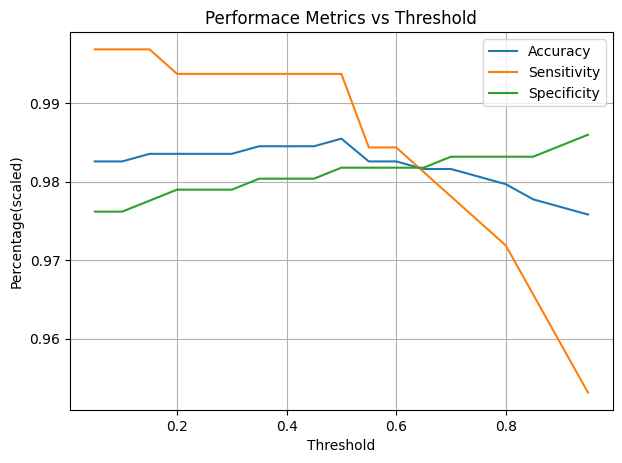

In [16]:
#Plotting Accuracy,Sensitivity,Specificity on different thresholds
plt.plot(thresholds,accuracies)
plt.plot(thresholds,sensitivities)
plt.plot(thresholds,specificities)
plt.legend(['Accuracy','Sensitivity','Specificity'])
plt.xlabel('Threshold')
plt.ylabel('Percentage(scaled)')
plt.grid(True)
plt.title('Performace Metrics vs Threshold')
plt.show()

**Q3. Plot the conclusion matrix and justify the reasoning behind these results.**

Observations: We can see that 318 true positives and 701 true negatives have been successfully identified. This is a good sign as most of the data points have been classified correctly. This happens because we have normalised our data. In the original dataset the ratio of emails of ham:spam is almost 2:1, to handle the uneven dataset, the probability (p_w_s) has been multiplied by 2 to have a perception of almost equal amount of data. Also the default values in in the vocabulary have been initialized differently to maintain the ratio 2:1 in ham:spam.

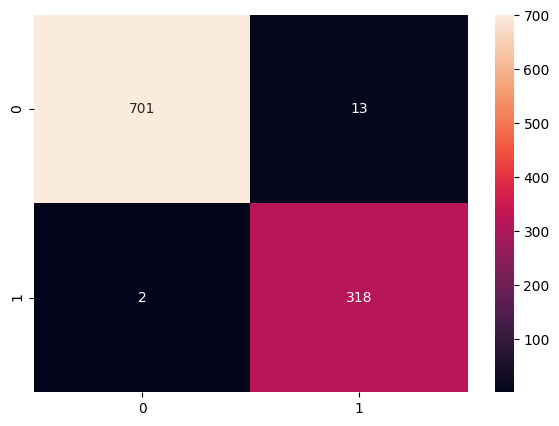

In [17]:
#Confusion matrix heatmap
ax = sns.heatmap(cf_matrix,annot=True,fmt="d")

**Q4. Apply the descriptive statistical techniques to the data and find out the centrality measures of the data, and compare (Visualize)  the centrality measures with the wrongly classified data.**



In [18]:
#Splitting spam_probabilities in correctly/wrongly classified
correctly_classified = []
wrongly_classified = []

for i in range(len(spam_probabilities)):
  if spam_probabilities[i][1] == test_data['label_num'][i]:
    correctly_classified.append(spam_probabilities[i][0])
  else:
    wrongly_classified.append(spam_probabilities[i][0])

Observations:
 
(a) Mean: Here we can see that the mean of correctly classified data is smaller than that of wrongly classified data, because as we have more number of hams, the predicted probablities are close to zero for hams. Complementing to this is the value of spam, i.e. 1.

(b) Meadian: The median of correctly classified data is very small due to similar reasons as in point(a), and this is also the expected result beacuse it tells us that the probabilities are very close to zero which is again a good sign considering the ratio of ham:spam.

(c) Mode: There is a very less chance that probabilities will repeat considering that probabilities are floating point values and the same is observed

In [19]:
#Calculating centrality measures differently for correctly/wrongly classified probabilities
mean_cc = statistics.mean(correctly_classified)
mean_wc = statistics.mean(wrongly_classified)

median_cc = statistics.median(correctly_classified)
median_wc = statistics.median(wrongly_classified)

mode_cc = statistics.mode(correctly_classified)
mode_wc = statistics.mode(wrongly_classified)

print('For correctly classified data:\nMean:',mean_cc,'\nMedian:',median_cc,'\nMode:',mode_cc,'\n')
print('For wrongly classified data:\nMean:',mean_wc,'\nMedian:',median_wc,'\nMode:',mode_wc,'\n')

For correctly classified data:
Mean: 0.3095959971745004 
Median: 9.965732465876965e-21 
Mode: 1.0 

For wrongly classified data:
Mean: 0.8424178826513422 
Median: 0.9989054915971156 
Mode: 1.0 



Observations: 

(a) Histogram 1: The histogram proves that almost all predicted probabilities are very close to zero and very close to one. There are very less values in between.

(b) Histogram 2: Most of the incorrect values here are close to ones which is proved by the confusion matrix, that there are more false positives (13) than false negatives (3).

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Frequency Histogram (correctly classified)')]

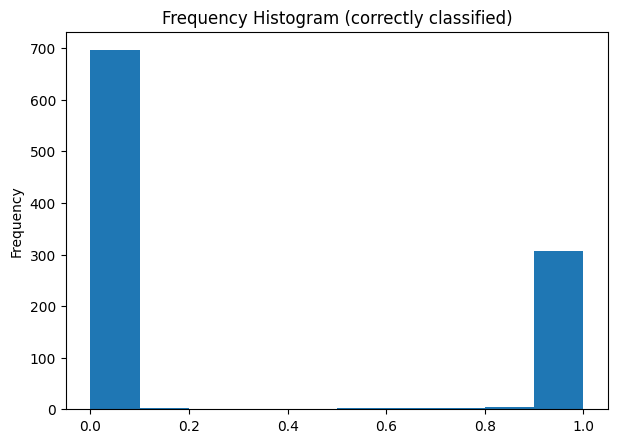

In [20]:
#Histogram of correctly classified probabilities
plt.hist(correctly_classified)
plt.gca().set(title='Frequency Histogram (correctly classified)', ylabel='Frequency')

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Frequency Histogram (wrongly classified)')]

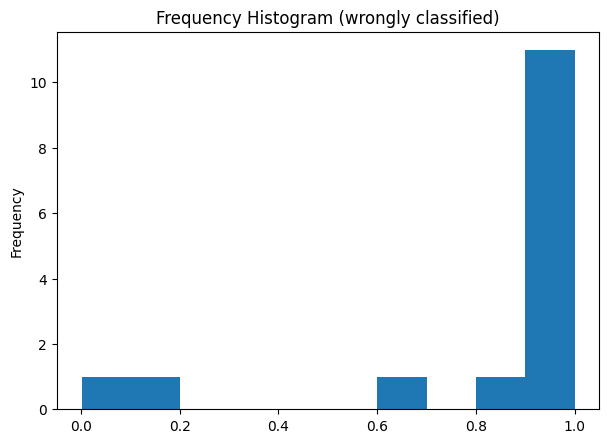

In [21]:
#Histogram of wrongly classified probabilities
plt.hist(wrongly_classified)
plt.gca().set(title='Frequency Histogram (wrongly classified)', ylabel='Frequency')

THANK YOU